# Model Selection Experiment

This notebook reports on an experiment to determine which class of model is suitable for the pokemon classification problem.

The experiments in this notebook require the processed version of the dataset. You need to run data_preparation at least once before using this notebook.

The sections of this notebook describe:
1) Experiment Setup: The goals and methodology of this project. 
2) Results: The results achieved with the experiment. 
3) Discussion: Comparison of all models based on the best versions determined in the respective sections.
4) Conclusion: Summary of the experiment results and other observations made. 

In [2]:
# Correct working directory. But only once. 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from keras.models import Sequential  # Model type to be used
from keras.layers import (
    Dense,
    Activation,
    Conv2D,
    Conv3D,
    LeakyReLU,
    Dropout,
    MaxPooling2D,
    MaxPooling3D,
    ZeroPadding2D,
    GlobalAveragePooling2D,
    Flatten
)   # Types of layer to be used in our model

from models.majority_guessing_benchmark import MajorityGuessingBenchmark
from models.random_guessing_benchmark import RandomGuessingBenchmark
from evaluation.evaluation_metrics import EvaluationMetrics
from data.dataset import Dataset

dataset = Dataset()

tf.compat.v1.enable_eager_execution() 

# 1) Experiment Setup

The purpose of this experiment is to identify which type of machine learning model is most promising for the Pokémon classification problem. The candidates are as follows: 
1) Naive Benchmarks: A naive benchmark consisting of guessing a random or the majority class. 
2) Simple Models: A basic (non-neural network) machine learning model.
3) ANN: An artificial neural network.
4) CNN: A convolutional neural network.

Each category will be covered by a sub-experiment in which we identify promising candidates and compare them against each other via manual exploration to determine the most promising candidate of the category. 
We will then compare the best candidates for all categories to determine which category is the most promising.

For comparison purposes, we have chosen the Hamming Score. Reasons for this choice are discussed in Section Evaluation Metrics.

The models are compared based on the same train/test split (be aware that it resets every time you run this notebook) but are not fixed to a random seed. This enables us to keep things comparable but to observe statistical variations stemming from randomness during the learning process. The splitting is done in Section Data Loading.


## Evaluation Metrics:

The problem we want to solve is a multilabel classification problem: Each pokemon is assigned one or more types. Some elaborations on this type of problem and the applicable evaluation metrics can be found [here](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff). For comparing models, we have identified the following metrics:

### Subset Accuracy = $\frac{1}{n}\sum_{i=1}^{n} I(Y_{true,i} = Y_{pred,i})$ 

This accuracy score counts all samples for which the predicted value $Y_{true,i}$ is the same as the expected value $Y_{pred,i}$ ($I$ turns the boolean comparison result into an integer with 1 being true and 0 being false). This metric is very strict. It does not distinguish between a completely wrong or partially wrong missclassification. 

### Hamming Score = $\frac{1}{n} \sum_{i=1}^{n} \frac{|Y_{true,i} \bigcap Y_{pred,i} |}{|Y_{true,i} \bigcup Y_{pred,i} |}$

This score is more fine-grained than the subset accuracy. It has a value of 1, if the predicted value $Y_{pred,i}$ is the same as $Y_{true,i}$ (the $\bigcap$ and $\bigcup$ operators are pairwise comparison of the labels and are the same if all labels are the same.) it gets smaller if there are wrong guesses or labels that haven't been recognized. There is also a hamming loss operation which operates after similar principles.


### F1 Score 

The F1 score is applicable to binary classification. Since we have a multilabel classification problem, we can't apply it directly. However, we can apply it to each pokemon type exclusively. This will give us the ability to understand which classes are easy and which classes are hard for the model to detect. More details on how to apply F1 scores to multilabel problems can be found [here](https://www.baeldung.com/cs/multi-class-f1-score).

### Summary

For this experiment we will use the Hamming Score as main comparison criteria over the subset accuracy as we want partially right answers to positively influence our score. 
We will record both subset accuracy and F1 scores as well to get more data to make observations from.

These metrics are calculated in the class EvaluationMetrics.  This class enables us to calculate all metrics based on a prediction and bundle them for comparison. It also provides a function for printing them to command line for manual inspection.



## Data Loading

Here, we load our data and split it in training and test data. This cell assumes that the data preparation has already been done and stored via the Dataset class.

Since our models will differ slightly in their data format compatibility, we create the following variations of our data:
- *X_train, X_test, y_train, y_test*: The original train and test data and labels created in data_preparation.ipynb. Each entry in X is an image (120x120x3) and each entry in y a multi-hot encoded vector of length 18.
- *X_train_flat, X_test_flat*: A flattened version of *X_train* and *X_test* for those models that require a one-dimensional vector as input.
- *y_train_prob*: An adapted version of the training labels to be compatible with a softmax function. In case of multiple classes, each value is reduced to 0.5, to represent probabilities. This has been done because the softmax function proved advantageous for convolutional neural networks in pre-tests.

In [3]:
X, y = dataset.get_prepared_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_flat = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]) # type: ignore
X_test_flat = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])   # type: ignore

y_train_prob = np.array([y_train[i] for i in range(len(y_train))])

# 2) Results

Here we report on the results of the four sub-experiments. 

## Benchmarks

Two simple benchmarks are possible for this problem:
* Random Guessing: Guesses one random class for each pokemon
* Majority Class Guessing: Always Guesses the Majority class "Water (identified in data_exploration.ipynb)

In the following cells, we run the models and save/print the results on the test set. Since these models do not learn, we are unconcerned with overfitting and omit the results on the training set. 

In [4]:
model = RandomGuessingBenchmark(dataset.get_labels())
y_pred_test = model.predict(X=X_test)   # type: ignore
random_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test) # type: ignore

random_test_metrics.print_evaluation_report(test_description="Random Guessing - Test Set")


Random Guessing - Test Set
- subset accuracy: 3 %
- hamming score 0.05
- f1-scores:  [0.18, 0.0, 0.0, 0.12, 0.14, 0.08, 0.1, 0.0, 0.0, 0.06, 0.15, 0.0, 0.0, 0.0, 0.13, 0.0, 0.0, 0.05]
- class accuracies:  [89, 90, 90, 91, 93, 85, 88, 85, 86, 79, 86, 87, 84, 91, 83, 91, 92, 75]


In [5]:
model = MajorityGuessingBenchmark(dataset.get_labels(), "Water")
y_pred_test = model.predict(X=X_test) # type: ignore
majority_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)  # type: ignore

majority_test_metrics.print_evaluation_report(test_description="Majority Guessing - Test Set")


Majority Guessing - Test Set
- subset accuracy: 8 %
- hamming score 0.13
- f1-scores:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31]
- class accuracies:  [91, 96, 96, 95, 96, 90, 91, 90, 95, 84, 94, 93, 86, 95, 88, 94, 96, 19]


### Results

Comparing both benchmarks, we notice that majority class guessing usually performs better than random guessing. It reached a hamming score of 0.12. We will thus use majority class guessing as the best representation of a benchmark model. 

## Simple Model
Here we test simple models on their performance for our data set.
To identify simple models that could be applicable we referred to the [Scikit-Learn Documentation ](https://scikit-learn.org/stable/modules/multiclass.html). We have tested all models listed to support multilabel classification, except for the Multi-layer Perceptron classifier, since neural networks are tested in their own test. 

Experimantation was done by running the below cell multiple times and changing the model and hyper parameters by hand in order to try to achieve good results. During the experiment, observations where recorded below the cell.

In [6]:
sk_model = DecisionTreeClassifier() 
# sk_model = KNeighborsClassifier(n_neighbors = 3)
# sk_model = RandomForestClassifier(max_depth=10)
# sk_model = RidgeClassifier()
# sk_model = RadiusNeighborsClassifier(radius = 70)
# sk_model = ExtraTreeClassifier()

sk_model.fit(X=X_train_flat, y=y_train)

y_pred_train = sk_model.predict(X=X_train_flat)
simple_test_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred_train)   # type: ignore
simple_test_metrics.print_evaluation_report(test_description="Simple Classifier - Training Set")

y_pred_test = sk_model.predict(X=X_test_flat)
simple_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test) # type: ignore
simple_test_metrics.print_evaluation_report(test_description="Simple Classifier - Test Set")


Simple Classifier - Training Set
- subset accuracy: 100 %
- hamming score 1.0
- f1-scores:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
- class accuracies:  [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

Simple Classifier - Test Set
- subset accuracy: 3 %
- hamming score 0.11
- f1-scores:  [0.27, 0.0, 0.31, 0.1, 0.0, 0.08, 0.17, 0.05, 0.0, 0.14, 0.1, 0.11, 0.19, 0.08, 0.19, 0.11, 0.0, 0.31]
- class accuracies:  [86, 94, 94, 89, 86, 86, 88, 78, 90, 77, 88, 90, 74, 86, 84, 90, 90, 78]


### Experiment Notes
During the experiment the following observations were recorded:
- **Decision Trees**: Without any restrictions, a Decision Tree Classifier has managed to get perfect scores on the training set. On the test set, it exhibits a hamming sore of around 0.14. To limit this obvious overfitting, we tried to experiment with the parameters *max_depth*, *min_samples_split* and *min_samples_leaf*. Using these parameters, it is possible to reduce the training scores, but the test scores did not improve significantly. During testing, we also noticed that the results are not very stable. They vary with reruns of the model on the sama datset.  In our tests they usually lie between accuracies of 7% and 10%  hamming scores of 0.1 and 0.15.
- **Extra Tree Classifier**: Behaved similarly to the Decision Tree Classifier. The scores achieved on the test set were consistently below those seen in Decision Tree Classifiers. 
- **Random Forest Classifier**: Random Forest Classifiers had a hard time classifying the test set. They seem to have overfit worse than decision trees and achieved zero scores on the test set even for low numbers of depths. Testing with different traing/test splits did not change this in our experiments. 
- **K Neighbors**: This classifier was tested with different numbers of neighbors and performed best with 3 neighbors. It achieved a hamming score of 0.06
- **Radius Neighbors Classifier**: To use this classifier for the test set, the radius had to be increased quite a lot (Otherwise, it wouldn't find a result). With this huge radius the performance is close to zero on the test set and not much better on the training set.
- **Ridge Classifier**: The Ridge Classifier achieved perfect scores on the training set and an a hamming score of 0.1 on the test set. 

### Results

Based on our tests, the Decision Tree Classifier produced the best results with a maximum hamming sore of 0.15 and will be used as benachmark for a simple model for this test. This number is on the high end for this model and was lower in some runs. Should this model not be out-performed by the other models, a more statistically sound test will be carried out. 

It should be noted that Ridge Classifiers achieved Hamming scores almost as good as te Decision Tree classifier. Should our experiments with Neural Networks fail, we would consider this classifier as a possible candidate as well. 


## Neural Networks
Here we test artificial neural networks on our pokemon classification. These networks are applied to the flattened version of the dataset. 

### Training Configuration

To find a suitable training setup we carried out preliminary experiments with different configurations. The design decisions made are reported here:
- A sigmoid activation function together with crossentropy as loss metric performed best in our tests and will be used. This re-interprets the multi-label probelm as classification problem with 18 outputs. A softmax activation function has also tested but performed worse.
- Neural Networks perform significantly better on inverted images. Our assumption is that this is due to the fact that the background, which is meaningless to our problem, is associated with a (0,0,0) value in the inverted version and thus does not cause any activation. The data preparation notebook was updated accordingly and now reflects this preprocessing step. Experiments on the other models showed that this does not reduce their results. 
- Initial experiments showed overfitting issues. In all experiments, the test loss diverged from the traning loss eventually. The exact epoch depended on the size of the model and the loss function. For this reason, it was decided to implement an early stopping callback that stops the traning process if no improvement on the test score has been achieved for five epochs. In this case, the configuration with the best validation loss is restored. 
- It was noted that a classification threshold of 0.15 leads to the best interpretation of the model output.


### Experiment Procedure
To find a good network configuration we use manual exploration starting at a network with 100 neurons and changing the configuration step by step towards better outcomes. The tested variations were based on personal judgement but followed the following loose procedure:
- The influence of increasing neuron numbers and adding layers is explored.
- Different transfer functions are tested (tanh, relu, leaky relu). These tests are performed initially - to identify which one works best - and sporadically when the network structure has changed sufficiently.
- Training time is limited to ten minutes. If the training was not finished by that time, it is stopped.

The test is performed by altering and re-running the below cell. During this process the tested configurations and their training and test scores were recorded. Notes and remarks are preserved in the markup cell below the experiment cell.

Epoch 1/100
21/21 [==============================] - 5s 240ms/step - loss: 0.3983 - val_loss: 0.2872
Epoch 2/100
21/21 [==============================] - 5s 231ms/step - loss: 0.2733 - val_loss: 0.2821
Epoch 3/100
21/21 [==============================] - 5s 228ms/step - loss: 0.2595 - val_loss: 0.2754
Epoch 4/100
21/21 [==============================] - 5s 260ms/step - loss: 0.2464 - val_loss: 0.2781
Epoch 5/100
21/21 [==============================] - 5s 253ms/step - loss: 0.2273 - val_loss: 0.2709
Epoch 6/100
21/21 [==============================] - 5s 248ms/step - loss: 0.2119 - val_loss: 0.2787
Epoch 7/100
21/21 [==============================] - 6s 267ms/step - loss: 0.1955 - val_loss: 0.2858
Epoch 8/100
21/21 [==============================] - 5s 248ms/step - loss: 0.1829 - val_loss: 0.2773
Epoch 9/100
21/21 [==============================] - 5s 236ms/step - loss: 0.1597 - val_loss: 0.2781
Epoch 10/100
21/21 [==============================] - 5s 234ms/step - loss: 0.1422 - val_lo

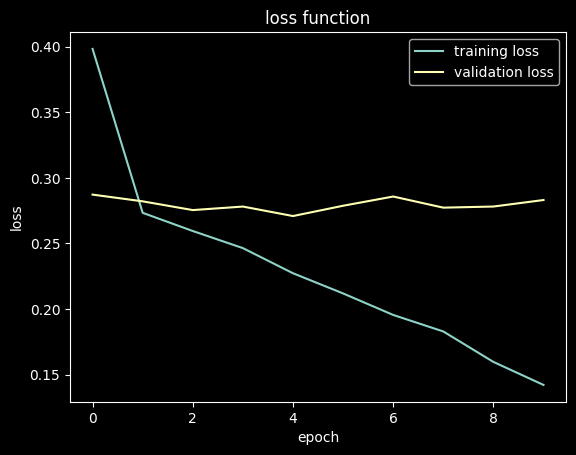

Stopped training after 10, epochs!
21/21 [==============================] - 1s 23ms/step

Artificial Neural Network - Training Set
- subset accuracy: 11 %
- hamming score 0.36
- f1-scores:  [0.35, 0.64, 0.48, 0.3, 0.43, 0.38, 0.62, 0.7, 0.06, 0.38, 0.43, 0.5, 0.66, 0.51, 0.61, 0.51, 0.34, 0.48]
- class accuracies:  [68, 95, 96, 95, 96, 84, 93, 94, 95, 66, 91, 97, 91, 89, 95, 90, 95, 72]
6/6 [==============================] - 0s 18ms/step

Artificial Neural Network - Test Set
- subset accuracy: 4 %
- hamming score 0.17
- f1-scores:  [0.22, 0.0, 0.0, 0.0, 0.0, 0.22, 0.36, 0.31, 0.0, 0.29, 0.12, 0.0, 0.25, 0.25, 0.0, 0.0, 0.25, 0.43]
- class accuracies:  [60, 88, 96, 95, 96, 74, 87, 89, 95, 59, 91, 91, 81, 81, 87, 88, 96, 67]


In [9]:
# Model initialization
tf_nn_model = Sequential(name="Sequential_NN")
tf_nn_model.add(Dense(units=1000, input_shape=(X_train_flat.shape[1],))) 
tf_nn_model.add(Activation(activation="tanh"))
tf_nn_model.add(Dense(y_train.shape[1]))  # type: ignore
tf_nn_model.add(Activation(activation="sigmoid"))
tf_nn_model.compile(loss="binary_crossentropy", optimizer="adam", run_eagerly=True)

# Train model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
history = tf_nn_model.fit(
    x=X_train_flat,
    y=y_train,
    epochs=100,
    validation_data=(X_test_flat, y_test),
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("loss function")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()

# Plot training results
print(f"Stopped training after {len(history.epoch)}, epochs!")

y_pred = tf_nn_model.predict(x=X_train_flat) > 0.15
ann_train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore
ann_train_metrics.print_evaluation_report(test_description="Artificial Neural Network - Training Set")

y_pred_test = tf_nn_model.predict(x=X_test_flat) > 0.15
ann_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore
ann_test_metrics.print_evaluation_report(test_description="Artificial Neural Network - Test Set")

### Experiment Notes

The training values have been recorded in "evaluation/experiment_records/Model Selection - ANN - Experiment.xlsx" in Sheet "Exploration Results". 


During the manual exploration we noted down our thoughts and findings and how they influenced the process:
- On the initial configuration, $tanh$ performed best. We continued experimenting with this transfer function. 
- We tried altering the model structure to learn a more simple model (10 neurons), a more complex model (1000 neurons) and a model with multiple layers (100,100). Both the introduction of more neurons and the additional layers increased the hamming score a little. The test with ten neurons had a learning curve that was a lot smoother (most other models tended to be finished learning meaningfull relations after one to five iterations), it also had the worst hamming score. From this we identified two avenues for further testing: 1) High Complexity Models with larger numbers of neurons and layers and 2) low complexity models trying to get a better generalization by low complexity. 
- High Complexity Models: In this category we tried extending the number of neurons to 1000, 2000 and 5000 in the first layer and add more layers. At 5000 Neurons the test exceeded our time limit. The best result remained the network with a single layer and 1000 neurons.
- Low Complexity Models: Testing in the low complexity area (< 100 neurons, single and multiple layers) yielded worse results than in the high complexity area.
- To double-check the selection of transfer functions, some configurations were also tested with *leaky rely* and *relu* as transfer functions. The result confirmed that *tanh* also performed best in those configurations.

### Results

Overall, the best score achieved was with two models: 
1) One layer with 1000 neurons and tanh function (0.19 hamming score)
2) Two layers with 100 neurons each and tanh function (018 hamming score)

It was noted that the training usually stopped with a test loss between 027 and 0.28 and that the overall hamming scores of the tested variations are fairly close to each other. This raised some concerns about the influence of statistical variance on the previous exporation. 

### Statistical Variance

One possible point weakness of the above method is that models were only learned a single time, which does not take into account the difference in resulst expected when rerunning the model from a different initial weight setup. To explore the statistical variance we ran the two best configurations ten time and recorded the results. They can be found in the same table in sheet "Variance Test". 
The statistical values of the hamming scores of both models are as follows:
| Model| Min | Max | Mean | St. Dev |
| ---- | --- | --- | ---- | ------- |
| 1    | 0.16 | 0.19 | 0.179 | 0.009 |
| 2    | 0.14 | 0.18 | 0.155 | 0.012 |

According to these values, model 1 is the best one with a mean hamming score of 0.18. The standard deviations proofed to be around 0.01 and may well have influenced our exploration. The results achieved should still be sufficient for this comparative experiment but may have to be revisited if scores of the different model types are within 0.1 of each other.

### Summary

We identified a model with a single hidden layer of 1000 neurons and a *tanh* transfer function to perform best for our dataset. This model reached an average score of 0.18. This will be the model we use for comparison with other models. 

As a side-note, this experiment showed that there are significiant overfitting issues. If neural networks are explored in the future, overfitting-avoidance mechanisms - such as dropout - may further increase performance.




## Convolutional Neural Networks
Here we test convolutional neural networks on our pokemon classification.

### Training Configuration

To find good training parameters, we performed a pretest by exploring different setups manually. The outcomes are:
- We noted that the softmax function (in combination with binary cross-entropy) performs significantly better than the sigmoid founction. Since this function will output a probability distribution we adjusted our test set by dividing each entry by the number of classes. This means, pokemon with 2 classes will have a 0.5 entry for each class instead of a 1. This should be compatible with the perfect outcome we would like to achieve for the softmax function.
- Initial experiments showed overfitting issues similar to neural networks. We use the same callback mechanism for early stopping in this experiment. 
- It was noted that a classification threshold of 0.1 leads to the best interpretation of the classification results, likely due to the high sparsity of the label vectors. 


### Experiment Procedure
To find a good network configuration we use a similar manual procedure as in the test of artificial neural networks. The tested variations were based on personal judgement but followed the following loose procedure:
- We started with one convolutional layer (16 3x3 filters) and one hidden layer of 100 neurons and tested different adjustments of the network complexity(more convolutional layers, more neurons, more dense layers, different filter sizes)
- We tested different transfer functions (*tanh*, *relu*, *leaky relu*). These tests are performed, whenever the network architecture has changed significantly.
- Training is stopped if it exceeds ten minutes.

The test is performed by altering and re-running the below cell. During this process the tested configurations and their training and test scores were recorded. Notes and remarks are preserved in the markup cell below the experiment cell.

Epoch 1/100
21/21 [==============================] - 2s 90ms/step - loss: 0.3125 - val_loss: 0.2767
Epoch 2/100
21/21 [==============================] - 2s 87ms/step - loss: 0.2688 - val_loss: 0.2747
Epoch 3/100
21/21 [==============================] - 2s 86ms/step - loss: 0.2563 - val_loss: 0.2673
Epoch 4/100
21/21 [==============================] - 2s 87ms/step - loss: 0.2362 - val_loss: 0.2678
Epoch 5/100
21/21 [==============================] - 2s 87ms/step - loss: 0.2063 - val_loss: 0.2686
Epoch 6/100
21/21 [==============================] - 2s 88ms/step - loss: 0.1674 - val_loss: 0.2690
Epoch 7/100
21/21 [==============================] - 2s 89ms/step - loss: 0.1274 - val_loss: 0.2737
Epoch 8/100
21/21 [==============================] - 2s 86ms/step - loss: 0.0944 - val_loss: 0.2796


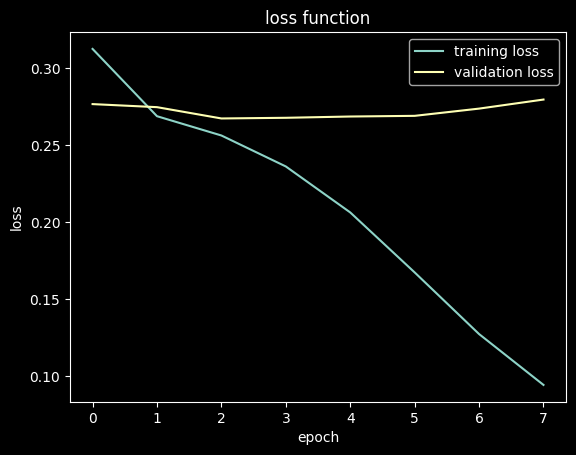

Stopped training after 8 epochs!
21/21 [==============================] - 0s 18ms/step

Convolutional Neural Network - Training Set
- subset accuracy: 11 %
- hamming score 0.31
- f1-scores:  [0.48, 0.26, 0.45, 0.33, 0.26, 0.05, 0.61, 0.61, 0.06, 0.47, 0.07, 0.0, 0.41, 0.27, 0.12, 0.0, 0.2, 0.39]
- class accuracies:  [90, 95, 93, 95, 95, 94, 95, 85, 95, 76, 91, 97, 67, 92, 91, 92, 94, 57]
6/6 [==============================] - 0s 14ms/step

Convolutional Neural Network - Test Set
- subset accuracy: 4 %
- hamming score 0.19
- f1-scores:  [0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.32, 0.0, 0.37, 0.0, 0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.39]
- class accuracies:  [85, 94, 92, 95, 96, 90, 93, 77, 95, 67, 94, 93, 56, 94, 88, 94, 96, 54]


In [8]:
# Build the model
in_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])   # type: ignore

tf_cnn_model = Sequential(name=f"Sequential_CNN")
tf_cnn_model.add(layer=Conv2D(filters=16, kernel_size=(3, 3), input_shape=in_shape, padding="same"))      
tf_cnn_model.add(layer=Activation(activation="tanh")) 
tf_cnn_model.add(layer=MaxPooling2D(pool_size=(2,2)))

tf_cnn_model.add(layer=Flatten())       

tf_cnn_model.add(layer=Dense(units=100))                                                 
tf_cnn_model.add(layer=Activation(activation="tanh"))          
tf_cnn_model.add(layer=Dense(y_train.shape[1])) # type: ignore
tf_cnn_model.add(layer=Activation(activation="softmax"))

tf_cnn_model.compile(loss="binary_crossentropy", optimizer="adam", run_eagerly=True)


# Training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,restore_best_weights=True)
history = tf_cnn_model.fit(x=X_train, y=y_train_prob, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Plot training history
plt.plot(history.history["loss"], label='training loss')
plt.plot(history.history["val_loss"],label='validation loss')
plt.title("loss function")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()


# Plot training results
print(f"Stopped training after {len(history.epoch)} epochs!")

y_pred = tf_cnn_model.predict(x=X_train) > 0.1
cnn_train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore
cnn_train_metrics.print_evaluation_report(test_description="Convolutional Neural Network - Training Set")

y_pred_test = tf_cnn_model.predict(x=X_test) > 0.1
cnn_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore
cnn_test_metrics.print_evaluation_report(test_description="Convolutional Neural Network - Test Set")

### Experiment Notes

The training values have been recorded in "evaluation/experiment_records/Model Selection - CNN - Experiment.xlsx" in Sheet "Exploration Results". 

During the manual exploration we noted down our thoughts and findings and how they influenced the process:
1) On the initial configuration, $tanh$ performed best, but the three transfer functions are so close that differences may be caused by variance. We continue with $tanh$ but will test the other functions again  on more complex network strutures where their differences may have a larger influence.
2) We explored the effect of different filter sizes by increasing to 5x5 and 7x7 filters. This slightly dropped the hamming score from 0.22 to 0.21. While this difference may be attributed to variance, it shows that bigger filter sizes are not leading to significant improvements, while taking more training time. It was thus decided to stick with a 3x3 filter.
3) Experiments with different filter numbers for the first layer showed that bigger filter numbers (32) come with slightly decreased hamming sores. In this experiment it was also apparent that the network overfit worse than with the lower number of filters. Testing smaller numbers of filters (8 and 4) showed no significant improvement.
4) Experiments with multiple layers resulted in mixed results. The best hamming score (0.23) was achieved with two layers and 16 neurons each. Three convolutional layers tended to worsen the results. 
5) To double-check the better score with two convolutional layers we ran that configuration 2 more times. It turned out the 0.23 hamming score was a fluke. 
6) Varying the number of neurons in the fully connected layer showed that there is indeed a sweet spot around 100. Lowering the number too much (10) reduced the hamming score drastically. Increasing it too much (1000) led to worse hamming scores. It was also obvious that the model started to overfit quickly at around 500 to 1000 neurons. This is not visible in the recorded values since we record the model at the point of the best test score. In the case of 1000 neurons, the model was already close to a loss of 0 on the training set five iterations after the test and training scores diverged.
7) We tried to increase the number of fully connected layers to two and  tried out different numbers of neurons for both. At 100,100 neurons, there was already obvious quick overfitting. For lower numbers of neurons (50,50 and 50,10) the results got noticably worse. 
8) We tried  increasing complexity in the convolutional part as well as the fully connected part. All tested combinations performed worse than our best so far. 
9) To re-validate the selection of *tanh*, we also ran one model with more convolutional and fully connected layers on *relu* and *leaky relu*. Again, all functions performed similarly. 

### Results

Sumarizing, our initial model achieved one of the best scores (altough multiple scores were close). This model had 1 convolutional layer with 16 3x3 filters and one fully connected layer with 100 neurons. It achieved a score of 0.22 hamming loss.

Generally, all our models performed similarly well (with some exceptions). As with neural networks, we were able to observe that the best loss for the training set is similar for most models at around 0.26, dropping below 0.26 on only a few occasions. At that point, the training and test loss usually stared to diverge and the model started to overfit on the training set while achieving worse results on the test set. 


### Statistical Variance

To get insights into variance between runs, we ran our best model ten times and recorded statistical information about the hamming score. The resulting values have been recorded in "evaluation/experiment_records/Model Selection - CNN - Experiment.xlsx" in Sheet "Variance Tests". 

| Model| Min | Max | Mean | St. Dev |
| ---- | --- | --- | ---- | ------- |
| 1    | 0.19 | 0.23 | 0.212 | 0.013 |

According to these values, the model has a mean hamming score of 0.21. The standard deiation is 0.013, meaning a lot of the other configurations tested are within an expected deviation from this one. While this makes us unsure whether the selected configuration is indeed the best one, it suffices to identify it as a comparison candidate for this experiment.

### Summary

Summarizing, we can say that Convolutional Neural Networks performed better than our simple model and our benchmark model. It beats these models by a minor margin that is nevertheless significant compared to the models own variation.

# 3) Discussion

The best results for all sub-experiments are summarized in the following table: 

| Model Type                   | Hamming Score |
| ---------------------------- | ------------- |
| Benchmark (Majority Class)   |   0.12        |
| Simple Model (DTC)           |   0.15        |
| Neural Network               |   0.18        |
| Convolutional Neural Network |   0.21        |

Based on these numbers we note the following:
* All machine learning models outperformed the simple benchmark. In the case of the simple model, this is debatable as we used the maximum value we've seen for this comparison.
* Neural Networks outperformed the simple model. Considering that we recorded the maximum value for the Hamming Score of the simple model and the average values of the neural networks, this is significant. The standard deviation of the neural network scores was around 0.1, which is significantly lower than the difference in scores. 
* Convolutional Neural Networks outperformed Neural Networks. Convolutional Neural Networks outperformed Neural Networks by 0.03 in the hamming score. Considering that the standard deviation of both is around 0.1, we consider this difference in scores to be significant. 

## Summary

Convolutional Neural Networks have shown themselfes to be the best option for further optimization. We will continue exploring our dataset based on this class of models.

During experimentation we gained the following additional insigts that will become relevant for future experiments:
* All models had significant issues with overfitting. This is likely due to the small size and big variation of the dataset, which makes it hard to learn patterns that generalize. It is likely that this will require changes on the dataset as well as the models. 
* Our ten minute training time restriction did not proof to stop us from exploring interesting avenues. This may indicate that the dataset can be learned with relatively low complexity models. 
* The statistical variance of learning results from different starting weights was big compared to differences between model configurations. This indicates that future experiments should always be based on statistical measures of multiple runs rather than single test runs.
* Rerunning this notebook shows that the scores achieved depend significantly on the test set. However, running the notebook multiple times showed that the CNN is still the best model in all cases. Thus, we assume the results reported transfer to other train-test splits


